In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.spatial.distance import cdist


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D, Input, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import BertTokenizer, BertModel

import torch

import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import xgboost
from xgboost import XGBClassifier

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from tqdm import tqdm

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/WordsofWar')

from BertSeqVect import BertSequenceVectorizer

# Enable tqdm progress bars on pandas
tqdm.pandas()

Mounted at /content/drive


In [2]:
# Print versions
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("nltk:", nltk.__version__)
print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:", tf.__version__)
print("transformers:", transformers.__version__)
print("xgboost:", xgboost.__version__)
print("imblearn:", imblearn.__version__)

numpy: 1.25.2
pandas: 1.5.3
nltk: 3.8.1
torch: 2.2.1+cu121
sklearn: 1.2.2
tensorflow: 2.15.0
transformers: 4.38.2
xgboost: 2.0.3
imblearn: 0.10.1


In [3]:
df = pd.read_csv('Speeches_War_Clean.csv')

## Class imbalance:

### We adjust this later via SMOTE

In [4]:
old_class_counts = df['War'].value_counts()
print(old_class_counts)

0    883
1     81
Name: War, dtype: int64


___

### Vectorization: Applying the vectorize method from the `BertSequenceVectorizer` class to each speech to convert them into fixed-length vectors.

Instantiate BERT tokenizer and model:

In [5]:
# Instantiate BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Process each transcript using the BERT-large-uncased model to obtain a fixed-length vector representation by using the `BertSequenceVectorizer` class (see BertSeqVect.py).

The resulting vectors are stored in `df` in the `ts_feature` column.

In [6]:
vectorizer = BertSequenceVectorizer()

# Apply BERT sequence vectorization to transcripts
df['ts_feature'] = df['Transcript'].progress_apply(lambda x: vectorizer.vectorize(x))

100%|██████████| 964/964 [01:56<00:00,  8.29it/s]


### Oversample via SMOTE:

Apply SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance. This effectively oversamples the minority class (`War=1`, in this case) to balance the class distribution. The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class, so we perform this via a pipeline that combines the two transformations.

Below we generate the resampled features, `X_resampled`, and corresponding labels, `y_resampled`.

In [7]:
print((df['ts_feature'][0]).shape)

(768,)


In [8]:
# Function to check if all arrays in a column have the same shape
def check_same_shape(arrays):
    shapes = [np.array(arr).shape for arr in arrays]
    return len(set(shapes)) == 1

In [9]:
# Check if all arrays in the 'arrays' column have the same shape
result = check_same_shape(df['ts_feature'])
print("All arrays have the same shape:", result)

All arrays have the same shape: True


In [10]:
# Extract features from 'ts_feature'
X = np.stack(df['ts_feature'].values)

In [11]:
# define pipeline
over = SMOTE(sampling_strategy=0.6, random_state=28)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=28)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [12]:
# Transform the data
X_resampled, y_resampled = pipeline.fit_resample(X, df['War'])

In [13]:
new_class_counts = y_resampled.value_counts()
new_class_counts = new_class_counts.sort_index()

print(new_class_counts)

0    661
1    529
Name: War, dtype: int64


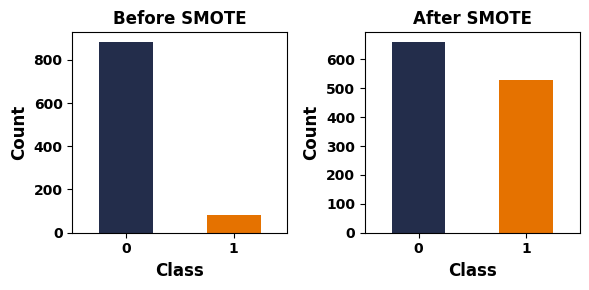

In [14]:
# Visualize change in class imbalance
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
old_class_counts.plot(kind='bar', color=['#232D4B', '#E57200'])
plt.title('Before SMOTE', weight='bold')
plt.xlabel('Class', weight='bold', size=12)
plt.ylabel('Count', weight='bold', size=12)
plt.xticks(rotation=0, weight='bold')  # Make xticks bold
plt.yticks(weight='bold')  # Make yticks bold

plt.subplot(1, 2, 2)
new_class_counts.plot(kind='bar', color=['#232D4B', '#E57200'])
plt.title('After SMOTE', weight='bold')
plt.xlabel('Class', weight='bold', size=12)
plt.ylabel('Count', weight='bold', size=12)
plt.xticks(rotation=0, weight='bold')  # Make xticks bold
plt.yticks(weight='bold')  # Make yticks bold

plt.tight_layout()
plt.show()

### Train/test split

In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                    y_resampled,
                                                    test_size=0.2,
                                                    random_state=28)

In [16]:
# Determine the input shape
input_shape = (X_train.shape[1:])

---

# CNN

In [117]:
# Define the neural network model
model = Sequential([
    Input(shape=input_shape),
    Dense(128,
          activation='relu',
          input_shape=(768,),
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [118]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [119]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.15)

Epoch 1/10
26/26 [==============================] - 1s 14ms/step - loss: 4.5186 - accuracy: 0.5439 - val_loss: 4.4256 - val_accuracy: 0.6154
Epoch 2/10
26/26 [==============================] - 0s 5ms/step - loss: 4.3991 - accuracy: 0.6082 - val_loss: 4.2694 - val_accuracy: 0.6643
Epoch 3/10
26/26 [==============================] - 0s 5ms/step - loss: 4.2318 - accuracy: 0.6119 - val_loss: 4.0758 - val_accuracy: 0.6853
Epoch 4/10
26/26 [==============================] - 0s 5ms/step - loss: 4.0051 - accuracy: 0.6724 - val_loss: 3.8459 - val_accuracy: 0.7622
Epoch 5/10
26/26 [==============================] - 0s 6ms/step - loss: 3.7536 - accuracy: 0.6959 - val_loss: 3.5835 - val_accuracy: 0.7413
Epoch 6/10
26/26 [==============================] - 0s 5ms/step - loss: 3.4854 - accuracy: 0.7256 - val_loss: 3.3190 - val_accuracy: 0.7413
Epoch 7/10
26/26 [==============================] - 0s 5ms/step - loss: 3.2477 - accuracy: 0.6860 - val_loss: 3.0729 - val_accuracy: 0.7552
Epoch 8/10
26/26 [=

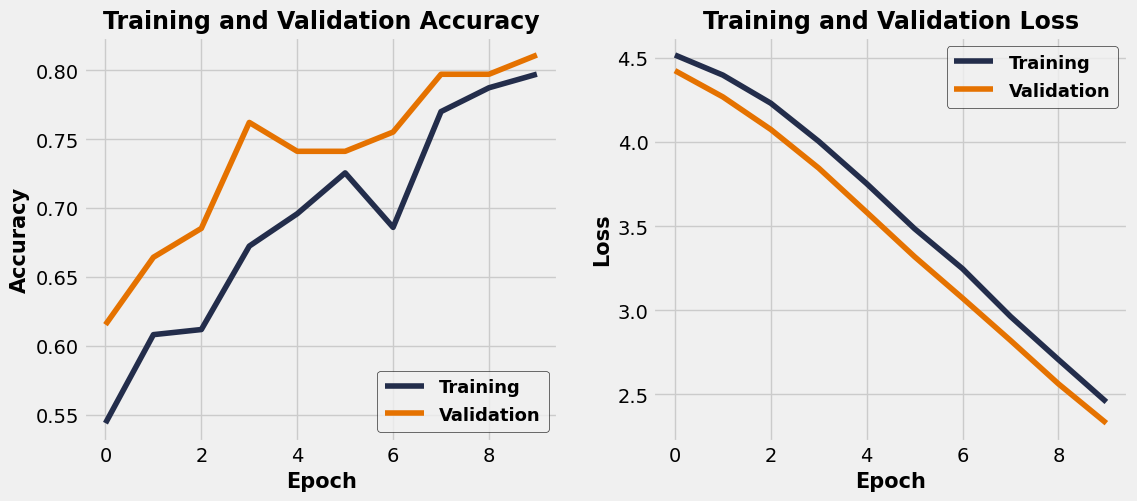

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Accuracy', weight='bold', size=15)
plt.plot(epochs_range, val_acc, label='Validation', color='#E57200')
legend = plt.legend(loc='lower right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Accuracy', weight='bold', size=17)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Loss', weight='bold', size=15)
plt.plot(epochs_range, val_loss, label='Validation', color='#E57200')
legend = plt.legend(loc='upper right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Loss', weight='bold', size=17)

plt.show()

In [121]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

8/8 [==============================] - 0s 2ms/step
AUC-ROC Score: 0.8364331026528259
F1-Score: 0.7272727272727273


---

# Gated RNN (LSTM)

In [113]:
# Reshape input_shape to add a timestep dimension
input_shape_with_timesteps = (1, input_shape[0])

# Define the neural network model
model2 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [114]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [115]:
# Train the model
history2 = model2.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.15)

Epoch 1/10
26/26 [==============================] - 4s 23ms/step - loss: 1.8223 - accuracy: 0.6007 - val_loss: 1.6012 - val_accuracy: 0.6643
Epoch 2/10
26/26 [==============================] - 0s 9ms/step - loss: 1.4693 - accuracy: 0.6724 - val_loss: 1.3265 - val_accuracy: 0.6783
Epoch 3/10
26/26 [==============================] - 0s 9ms/step - loss: 1.1964 - accuracy: 0.7206 - val_loss: 1.0215 - val_accuracy: 0.7832
Epoch 4/10
26/26 [==============================] - 0s 9ms/step - loss: 0.9607 - accuracy: 0.7998 - val_loss: 0.8858 - val_accuracy: 0.7622
Epoch 5/10
26/26 [==============================] - 0s 10ms/step - loss: 0.8000 - accuracy: 0.8146 - val_loss: 0.6909 - val_accuracy: 0.8531
Epoch 6/10
26/26 [==============================] - 0s 9ms/step - loss: 0.6270 - accuracy: 0.8850 - val_loss: 0.6220 - val_accuracy: 0.8392
Epoch 7/10
26/26 [==============================] - 0s 9ms/step - loss: 0.5669 - accuracy: 0.8752 - val_loss: 0.6506 - val_accuracy: 0.7343
Epoch 8/10
26/26 [

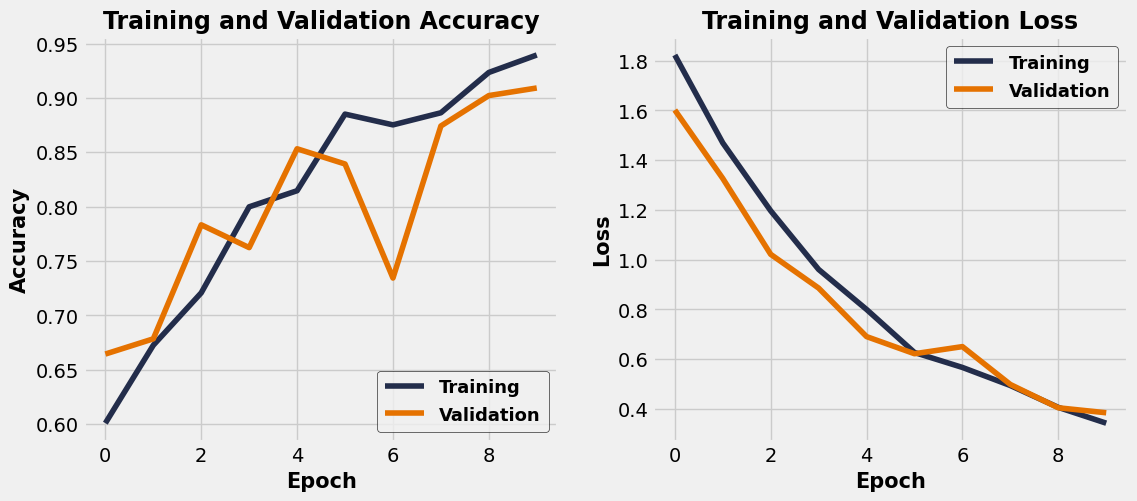

In [116]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(10)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Accuracy', weight='bold', size=15)
plt.plot(epochs_range, val_acc2, label='Validation', color='#E57200')
legend = plt.legend(loc='lower right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Accuracy', weight='bold', size=17)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Loss', weight='bold', size=15)
plt.plot(epochs_range, val_loss2, label='Validation', color='#E57200')
legend = plt.legend(loc='upper right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Loss', weight='bold', size=17)

plt.show()

In [28]:
# Predict probs for positive class
y_pred_prob2 = model2.predict(X_test)

# AUC-ROC score
auc_roc2 = roc_auc_score(y_test, y_pred_prob2)

# Convert probs to class labels
y_pred_class2 = (y_pred_prob2 > 0.5).astype(int)

# F1-score
f12 = f1_score(y_test, y_pred_class2)

print("AUC-ROC Score:", auc_roc2)
print("F1-Score:", f12)

8/8 [==============================] - 0s 3ms/step
AUC-ROC Score: 0.9684256055363322
F1-Score: 0.9017857142857143


---

# Comments on model results:

These results possibly indicate that there are discernible patterns in the text of US presidential speeches that correlate with the US entering a major war  within one year of the speech. This (I think) suggests that Presidents leverage certain language or rhetorical cues in their speeches to prepare the nation for war.

---

# Next Steps:

Professor mentioned that it would be interesting if we can try to identify discriminative features between the two classes (i.e., Interpretable Learning). So, see if we could answer questions like: What is the model seeing in the speech that makes it classify it as leading up to war or what is missing in the other class that makes it classify that way?

To tackle this we might consider:

### __1__: Layer-wise Relevance Propagation (LRP):

Implement LRP to understand the relevance of input features to the model's predictions. This can help us identify which words or phrases in the speeches contribute most significantly to the classification decision.

### __2__: SHAP (SHapley Additive exPlanations):

Use SHAP values to compute the importance of each feature in the context of individual predictions. This technique will provide insights into how each feature influences the model's output.

### __3__: Feature Importance Scores:

After training your model, extract the weights of the first layer (Dense(128)) and analyze which input features have the highest weights. This can give us an idea of which words or phrases are most influential in determining the classification.

### __4__: Attention Mechanisms:

If applicable, incorporate attention mechanisms into your model architecture. Attention mechanisms can highlight which parts of the input sequence are most relevant for making predictions, providing interpretability at the token level.

### __5__: Word Embedding Visualization:

Visualize word embeddings to understand how words are represented in the model's embedding space. This can help us identify clusters of words associated with specific classes (e.g., words related to war).

### __6__: Grad-CAM (Gradient-weighted Class Activation Mapping):

If we use a model architecture with convolutional layers, we might consider apply Grad-CAM to visualize which parts of the input text are most important for the model's predictions. This technique highlights regions of the input that contribute most to the final decision.

---

Since we use an LSTM model, attention mechanisms can be particularly useful in understanding which parts of the input sequences are most relevant for classification.

Here's how we can implement attention mechanisms with our LSTM model:

Define an Attention Layer: Define a custom attention layer that calculates attention weights based on the LSTM output.

Modify the Model: Modify the existing model to incorporate the attention layer.

Analyze Attention Weights: Analyze the attention weights to understand which parts of the input sequences are important for classification.

In [98]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.matmul(x, self.W) + self.b
        at = tf.nn.softmax(et, axis=1)
        output = x * at
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [103]:
# Modify the model to include attention layer
model3 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1,
         return_sequences=True),
    AttentionLayer(),  # Add attention layer
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [104]:
# Compile and train the model as before
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [105]:
# Train the model
history3 = model3.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.15)

Epoch 1/10
26/26 [==============================] - 4s 25ms/step - loss: 1.8021 - accuracy: 0.5933 - val_loss: 1.5660 - val_accuracy: 0.6923
Epoch 2/10
26/26 [==============================] - 0s 11ms/step - loss: 1.4599 - accuracy: 0.6329 - val_loss: 1.2653 - val_accuracy: 0.7133
Epoch 3/10
26/26 [==============================] - 0s 10ms/step - loss: 1.1727 - accuracy: 0.7194 - val_loss: 1.0025 - val_accuracy: 0.8112
Epoch 4/10
26/26 [==============================] - 0s 10ms/step - loss: 0.9458 - accuracy: 0.7824 - val_loss: 0.8283 - val_accuracy: 0.8042
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.7612 - accuracy: 0.8245 - val_loss: 0.6857 - val_accuracy: 0.8462
Epoch 6/10
26/26 [==============================] - 0s 10ms/step - loss: 0.6208 - accuracy: 0.8677 - val_loss: 0.5276 - val_accuracy: 0.8951
Epoch 7/10
26/26 [==============================] - 0s 10ms/step - loss: 0.5212 - accuracy: 0.8801 - val_loss: 0.4560 - val_accuracy: 0.9091
Epoch 8/10
26

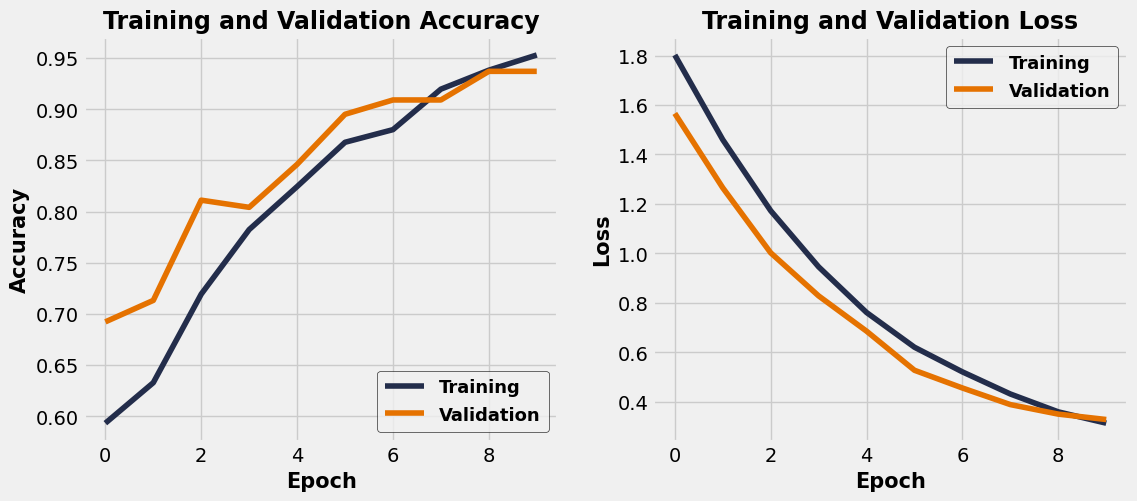

In [106]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(10)


plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Accuracy', weight='bold', size=15)
plt.plot(epochs_range, val_acc3, label='Validation', color='#E57200')
legend = plt.legend(loc='lower right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Accuracy', weight='bold', size=17)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training', color='#232D4B')
plt.xlabel('Epoch', weight='bold', size=15)
plt.ylabel('Loss', weight='bold', size=15)
plt.plot(epochs_range, val_loss3, label='Validation', color='#E57200')
legend = plt.legend(loc='upper right')
plt.setp(legend.texts, weight='bold', size=13)  # Set legend text to bold
legend.get_frame().set_edgecolor('black')  # Set legend outline color to black
plt.title('Training and Validation Loss', weight='bold', size=17)

plt.show()

In [107]:
# Predict probs for positive class
y_pred_prob3 = model2_with_attention.predict(X_test)

# AUC-ROC score
auc_roc3 = roc_auc_score(y_test, y_pred_prob3)

# Convert probs to class labels
y_pred_class3 = (y_pred_prob3 > 0.5).astype(int)

# F1-score
f13 = f1_score(y_test, y_pred_class3)

print("AUC-ROC Score:", auc_roc3)
print("F1-Score:", f13)

8/8 [==============================] - 0s 3ms/step
AUC-ROC Score: 0.976138985005767
F1-Score: 0.9099099099099098


In [108]:
# Analyze Attention Weights
attention_model = Model(inputs=model2_with_attention.input, outputs=model2_with_attention.layers[4].output)
attention_weights = attention_model.predict(X_train)

30/30 [==============================] - 0s 3ms/step


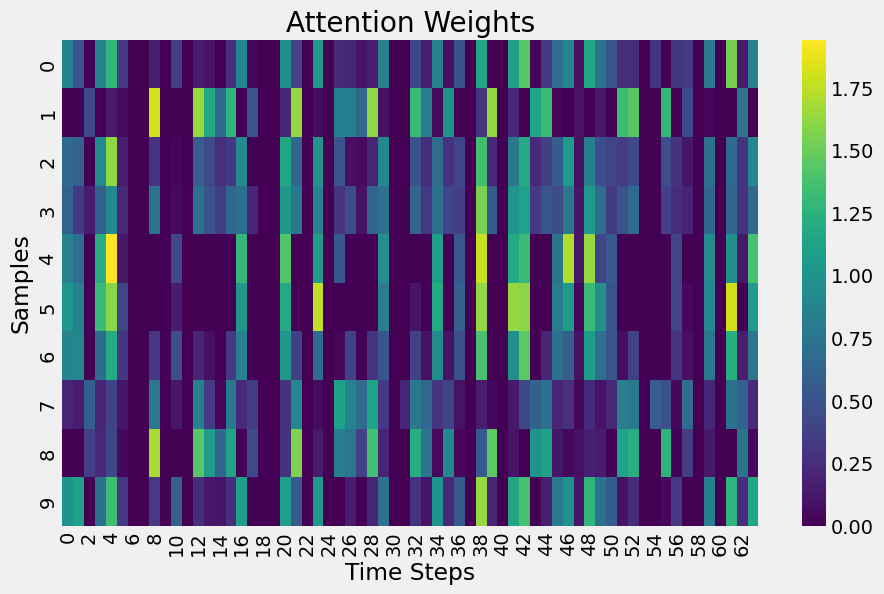

In [109]:
# Visualize Attention Weights
plt.figure(figsize=(10, 6))
sns.heatmap(attention_weights[:10], cmap='viridis')
plt.title('Attention Weights')
plt.xlabel('Time Steps')
plt.ylabel('Samples')
plt.show()

In [110]:
# Calculate summary statistics of attention weights for each class
mean_attention_wt_class_0 = np.mean(attention_weights[y_train == 0], axis=1)
mean_attention_wt_class_1 = np.mean(attention_weights[y_train == 1], axis=1)

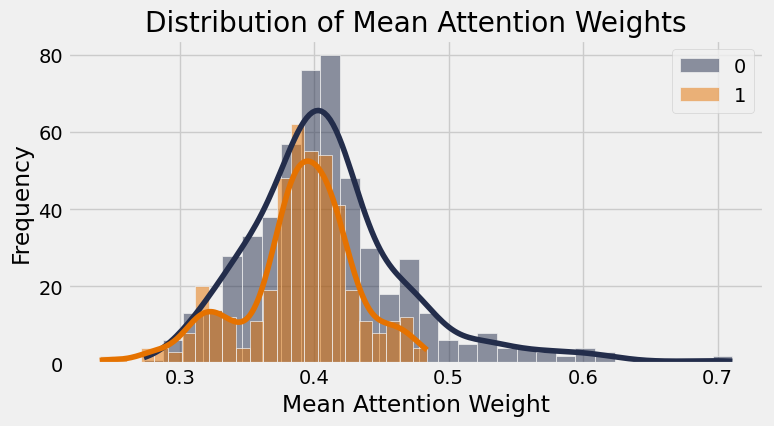

In [111]:
plt.figure(figsize=(8, 4))
sns.histplot(mean_attention_wt_class_0, color='#232D4B', label='0', kde=True)
sns.histplot(mean_attention_wt_class_1, color='#E57200', label='1', kde=True)
plt.title('Distribution of Mean Attention Weights')
plt.xlabel('Mean Attention Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [112]:
# Perform statistical tests to compare attention weights between classes
t_stat, p_value = ttest_ind(mean_attention_wt_class_0, mean_attention_wt_class_1)
print(f"T-Statistic: {t_stat}, p-value: {p_value}")

T-Statistic: 6.326273104696891, p-value: 3.862597457070641e-10


We could use the `cosine_similarity` function from `sklearn.metrics.pairwise` to compute the cosine similarity matrix between pairs of BERT sequence vectors, then visualize the cosine similarity matrix as a heatmap using `seaborn` to identify patterns of similarity between different speeches.

This visualization maybe can help us understand the semantic relationships between different speeches in our dataset. We can further analyze the clusters and outliers identified in the heatmap to gain insights into the semantic content of the speeches.

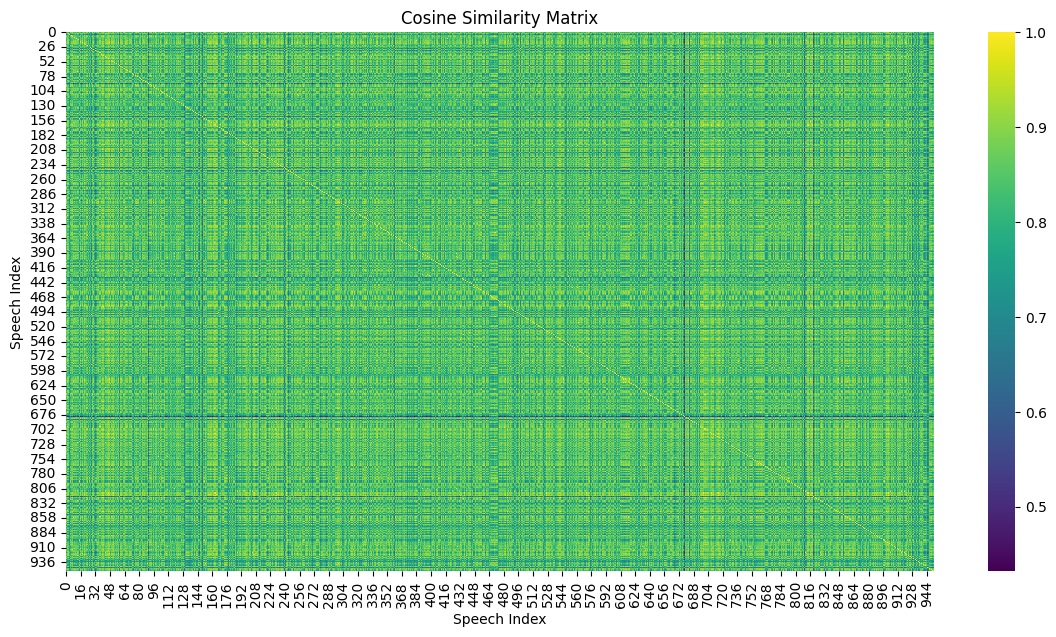

In [71]:
# Calculate cosine similarity matrix
cos_sim_matrix = cosine_similarity(X_train)

# Visualize similarity matrix as heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(cos_sim_matrix, cmap='viridis')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Speech Index')
plt.ylabel('Speech Index')
plt.show()


After computing the cosine similarity matrix and visualizing it as a heatmap, we have some options for further analysis and exploration. Below, we experiment with applying k-means clustering to group similar speeches based on their cosine similarity. This could help identify coherent clusters of speeches with similar semantic content.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


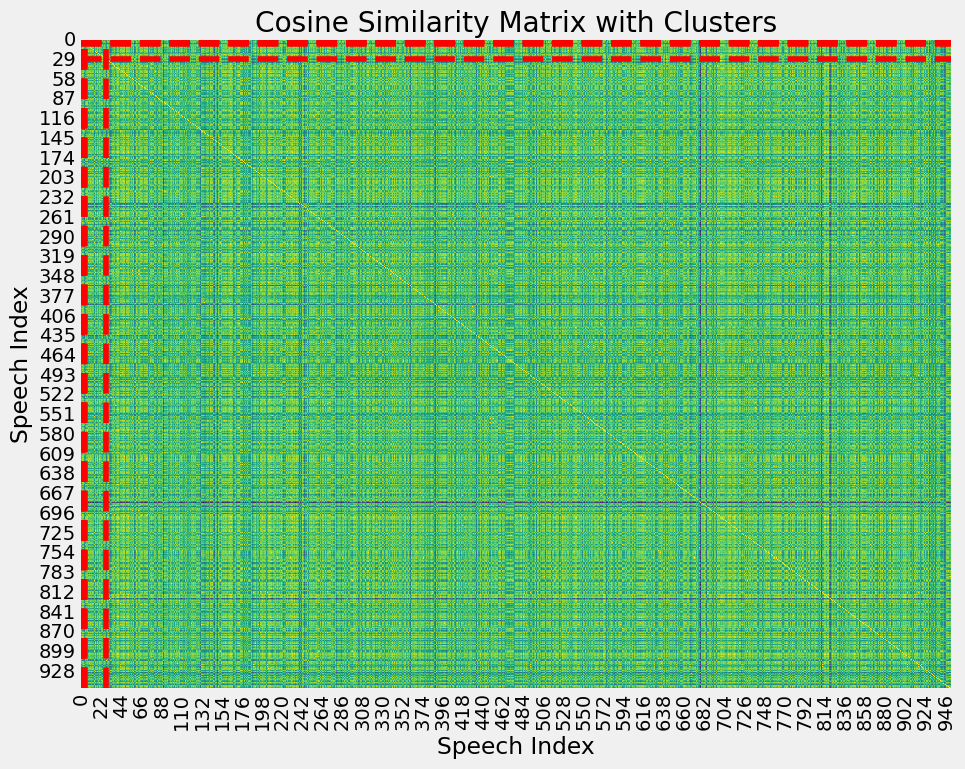

In [128]:
# Define the number of clusters
num_clusters = 5

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cos_sim_matrix)

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_matrix, cmap='viridis', cbar=False)
plt.title('Cosine Similarity Matrix with Clusters')
plt.xlabel('Speech Index')
plt.ylabel('Speech Index')

# Draw cluster boundaries
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    plt.axvline(x=min(cluster_indices), color='red', linestyle='--')
    plt.axhline(y=min(cluster_indices), color='red', linestyle='--')

plt.show()

I have no idea how to interpret that plot above ... so perhaps we instea try and use t-SNE to reduce the dimensionality of the BERT sequence vectors to two dimensions, allowing us to visualize the speeches in a 2D scatter plot?

We plot each speech as a point in the scatter plot, with the color of the point representing its assigned cluster label.

This visualization provides a more intuitive representation of the clustering results, allowing us to observe the spatial distribution of speeches in the reduced-dimensional space.

Each point represents a speech, and points belonging to the same cluster are  grouped together. This visualization will can help us understand how the speeches are clustered based on their semantic similarity and identify any discernible patterns or structures.

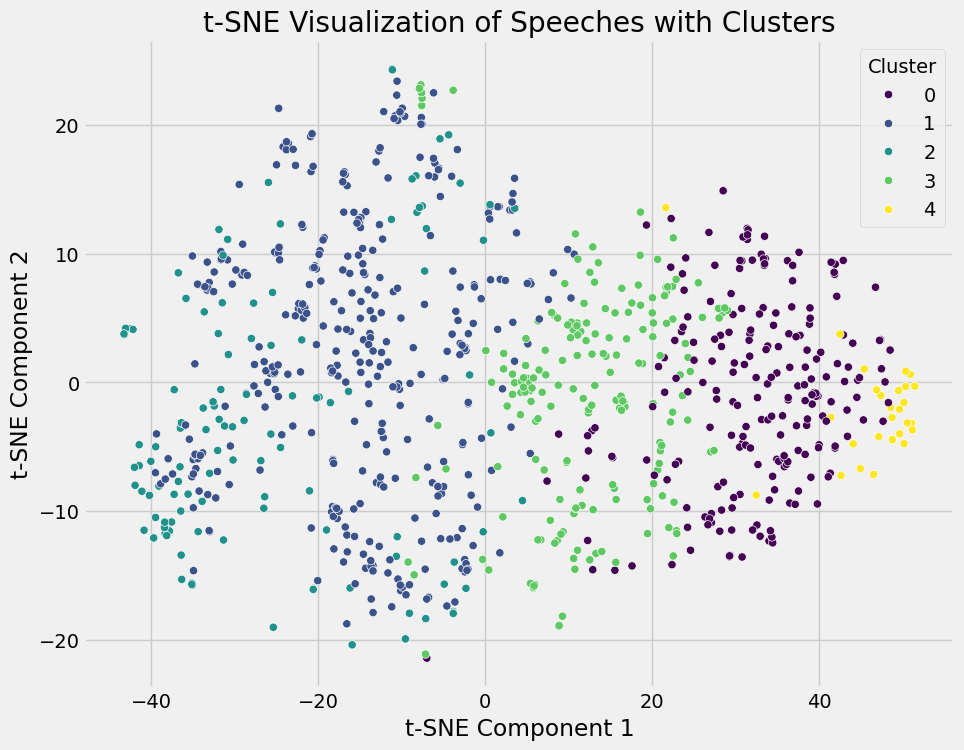

In [129]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
speech_embeddings_2d = tsne.fit_transform(X_train)

# Visualize the speeches in a 2D scatter plot with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=speech_embeddings_2d[:, 0], y=speech_embeddings_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Speeches with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

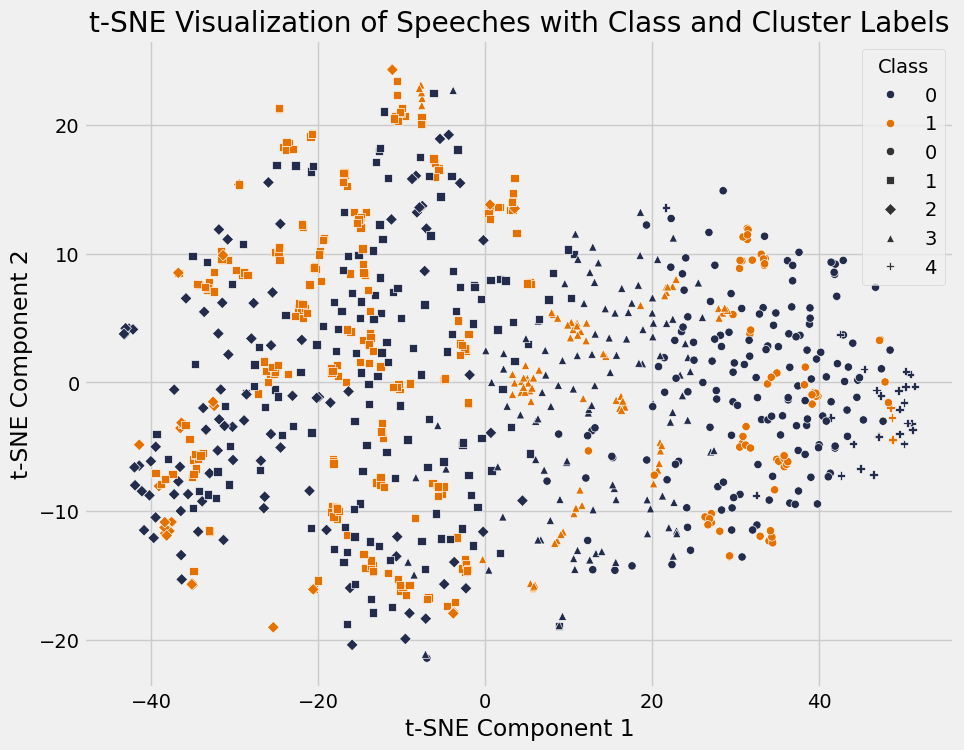

In [130]:
# Define custom colors for class labels
class_colors = ['#232D4B', '#E57200']

# Visualize the speeches in a 2D scatter plot with both class and cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=speech_embeddings_2d[:, 0], y=speech_embeddings_2d[:, 1], hue=y_train, palette=class_colors,
                style=cluster_labels, markers=['o', 's', 'D', '^', 'P'], legend='full')
plt.title('t-SNE Visualization of Speeches with Class and Cluster Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class', loc='upper right')
plt.show()

Not positive how to interpret that either, but maybe interesting?

After clustering the speeches, we could analyze the characteristics of each cluster to gain insights into the semantic content represented by each group. For example, we could compute the centroid of each cluster, which represents the "average" speech within the cluster in the reduced-dimensional space.

Then we could examine the speeches closest to each cluster centroid to understand the common themes or topics represented by the cluster.

Finally, we could visualize the distribution of speeches within each cluster to identify any patterns or trends.

In [76]:
# Calculate cluster centroids
cluster_centroids = []
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_centroid = np.mean(speech_embeddings_2d[cluster_indices], axis=0)
    cluster_centroids.append(cluster_centroid)

# Analyze cluster characteristics
for i, centroid in enumerate(cluster_centroids):
    cluster_indices = np.where(cluster_labels == i)[0]
    distances = cdist([centroid], speech_embeddings_2d[cluster_indices], 'euclidean')[0]
    closest_indices = cluster_indices[np.argsort(distances)[:5]]  # Get indices of 5 closest speeches to centroid
    print(f"Cluster {i} Characteristics:")
    for idx in closest_indices:
        print(f"- Speech {idx}: {df.iloc[idx]['Transcript'][:100]}...")  # Print first 100 characters of speech
    print("\n")

Cluster 0 Characteristics:
- Speech 847: mr speaker mr vice president members of the 105th congress distinguished guests my fellow americans ...
- Speech 743: id intended to make some remarks about the problem of social security tonight but the immediacy of c...
- Speech 482: this campaign is more than a contest between two men it is more than a contest between two parties i...
- Speech 588: mr vice president my old colleague from massachusetts and your new speaker john mccormack members of...
- Speech 618: my fellow americans i am about to sign into law the civil rights act of 1964 i want to take this occ...


Cluster 1 Characteristics:
- Speech 673: members of the congress members of the cabinet distinguished americans and guests on an april aftern...
- Speech 741: father hesburgh i thank you very much and for so many things the distinguished honor that youve conf...
- Speech 277: to the senate i transmit herewith the report of the secretary of state and the accompanying papers i...


Interesting? But what about the outliers?

Outliers are speeches that are significantly dissimilar to other speeches within their respective clusters. Evaluating outliers can provide insights into unique or distinct topics present in the dataset. We can compute outlier scores for each speech based on its distance from the centroid of its cluster or using other outlier detection techniques. Then, we can examine the transcripts of identified outliers to understand their unique characteristics or topics.

In [77]:
# Evaluate outliers
for i, centroid in enumerate(cluster_centroids):
    cluster_indices = np.where(cluster_labels == i)[0]
    distances = cdist([centroid], speech_embeddings_2d[cluster_indices], 'euclidean')[0]
    outlier_indices = cluster_indices[np.argsort(distances)[-5:]]  # Get indices of 5 farthest speeches from centroid
    print(f"Cluster {i} Outliers:")
    for idx in outlier_indices:
        print(f"- Speech {idx}: {df.iloc[idx]['Transcript'][:100]}...")  # Print first 100 characters of speech
    print("\n")

Cluster 0 Outliers:
- Speech 640: dr nabrit my fellow americans i am delighted at the chance to speak at this important and this histo...
- Speech 583: general gavan mr gleason members of the military forces veterans fellow americans today we are here ...
- Speech 402: mr chairman and fellow citizens we are assembled to celebrate the one hundred and thirty eighth anni...
- Speech 579: admiral mr secretary members of the joint chiefs of staff members of the faculty members of the grad...
- Speech 426: i sincerely regret that i can not be present at the opening of this session of the congress i am thu...


Cluster 1 Outliers:
- Speech 220: to the house of representatives i have considered the bill entitled âan act supplementary to an act ...
- Speech 268: with devout gratitude to the bountiful giver of all good i congratulate you that at the beginning of...
- Speech 381: my fellow citizens anyone who has taken the oath i have just taken must feel a heavy weightof respon...
- Speech 549: 